In [531]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import math
import seaborn as sns
import impyute as impy

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [532]:
pd.set_option('display.max_rows', 500)
%matplotlib inline

In [533]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [534]:
cleaned_dataset = pd.read_csv('cleaned_dataset.csv')

In [535]:
# drop cloumn Unnamed: 0

# Fixing date column datatype
cleaned_dataset['date'] = pd.to_datetime(cleaned_dataset['date']);
# all_countries_dataset['location'] = all_countries_dataset['location'].astype('category');
# all_countries_dataset['continent'] = all_countries_dataset['continent'].astype('category');

# all_countries_dataset.set_index('date', inplace=True)

In [536]:
# take only numerical variables
numerical_variables = [
    'new_cases',
    'new_deaths',
    'icu_patients',
    'new_tests',
    'positive_rate',
    'people_vaccinated',
    'new_vaccinations',
    'total_boosters',
    'stringency_index'
]

# take non-numerical variables
non_numerical_variables = [
    'continent',
    'location',
    'date'
]

svr_dataset = cleaned_dataset.copy()

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

obj_dataset = svr_dataset[non_numerical_variables].copy()
num_dataset = svr_dataset[numerical_variables].copy()
# num_dataset = sc.fit_transform(num_dataset)

num_dataset = pd.DataFrame(num_dataset, columns=numerical_variables)


num_dataset = np.log(num_dataset)

# Take First Difference to Remove Trend
num_dataset = num_dataset.diff()

num_dataset = num_dataset.diff()

# Remove Increasing Volatility
# num_dataset = num_dataset.groupby(num_dataset.index.year).std()

svr_dataset = pd.concat([obj_dataset, pd.DataFrame(data=num_dataset, columns=numerical_variables)], axis=1)

svr_dataset.dtypes

continent                    object
location                     object
date                 datetime64[ns]
new_cases                   float64
new_deaths                  float64
icu_patients                float64
new_tests                   float64
positive_rate               float64
people_vaccinated           float64
new_vaccinations            float64
total_boosters              float64
stringency_index            float64
dtype: object

In [537]:
svr_dataset.index = pd.to_datetime(svr_dataset.date)
svr_dataset.index.freq = svr_dataset.index.inferred_freq

In [538]:
def replace_nans(dataset):
    # for each country
    new_dataset = pd.DataFrame()

    for country in dataset['location'].unique():
        country_dataset = dataset[dataset['location'] == country]

        for variable in numerical_variables:
            for index, row in country_dataset.iterrows():
                if pd.isna(row[variable]) or row[variable] == float('inf') or row[variable] == float('-inf'):
                    previous_timestamp = index - pd.Timedelta(days=1)
                    if previous_timestamp in country_dataset.index and pd.isna(country_dataset.loc[previous_timestamp, variable]) == False:
                        country_dataset.at[index, variable] = country_dataset.at[previous_timestamp, variable]
                    else:
                        country_dataset.at[index, variable] = 0
    
        new_dataset = pd.concat([new_dataset, country_dataset], axis=0)

    return new_dataset

In [539]:
svr_dataset = replace_nans(svr_dataset)

### Add lags

In [540]:
nb_lags_dependent = 1 # calculated with AutoARIMA
nb_lags_independent = 1 # calculated with AutoARIMA

vars_to_lag = [
    # 'icu_patients',
    # 'new_tests',
    # 'new_vaccinations'
]

# for each variable
for variable in vars_to_lag:
    if variable == 'new_deaths':
        continue
    for nb_lag in range(0, nb_lags_independent):
        svr_dataset[variable + '_lag' + str(nb_lag)] = svr_dataset[variable].shift(nb_lag)

for nb_lag in range(nb_lags_dependent):
    svr_dataset['new_deaths_lag' + str(nb_lag)] = svr_dataset['new_deaths'].shift(nb_lag)

In [541]:
# remove nan values created by shift()
svr_dataset = svr_dataset.dropna()

### Remove non-lagged variables

In [542]:
print(svr_dataset.columns.tolist())
predictors = svr_dataset.columns.tolist()
# leave only those that contain '_lag'
predictors = [x for x in predictors if '_lag' in x]
# add date and new_deaths
predictors.append('new_deaths')

predictors

['continent', 'location', 'date', 'new_cases', 'new_deaths', 'icu_patients', 'new_tests', 'positive_rate', 'people_vaccinated', 'new_vaccinations', 'total_boosters', 'stringency_index', 'new_deaths_lag0']


['new_deaths_lag0', 'new_deaths']

### Add dummy variables

In [543]:
countries = svr_dataset['location'].unique()

In [544]:
# for each country
for country in svr_dataset['location'].unique():
    # set empty column with 0 values for svr_dataset[country]
    predictors.append(country)
    svr_dataset[country] = 0
    svr_dataset[country].loc[svr_dataset['location'] == country] = 1

# drop location column
# svr_dataset = svr_dataset.drop(columns=['location'])
# drop continent column
# svr_dataset = svr_dataset.drop(columns=['continent'])

/home/ion/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [545]:
# find max date
max_date = svr_dataset['date'].max()
min_date = svr_dataset['date'].min()
print(min_date)
print(max_date)

2020-01-06 00:00:00
2021-11-01 00:00:00


In [546]:
# import SVR
from sklearn.svm import SVR


def svr(svr_train_dataset):
    y = svr_train_dataset['new_deaths']

    pp = [x for x in predictors if x != 'new_deaths']
    X = svr_train_dataset[pp]

    svr_model = SVR()
    svr_model.fit(X, y)

    return svr_model

In [547]:
def svr_predict(model, country, svr_test_dataset, plot):
    y_test = svr_test_dataset['new_deaths'].loc[svr_test_dataset[country] == 1]

    pp = [x for x in predictors if x != 'new_deaths']
    X_test = svr_test_dataset[pp].loc[svr_test_dataset[country] == 1]
    
    predictions = model.predict(X_test)

    print("Country: {} - C: {} - SVR Score: {}".format(country, model.C, model.score(X_test, y_test)))
 
    if plot:
        # plot predictions vs actual
        plt.figure(figsize=(20, 5))
        plt.plot(svr_test_dataset['date'].loc[svr_test_dataset[country] == 1], predictions, label='Predictions')
        plt.plot(svr_test_dataset['date'].loc[svr_test_dataset[country] == 1], y_test, label='Actual')
        plt.xlabel("Date")
        plt.ylabel("New Deaths")
        plt.title(country)
        plt.legend()
        plt.show()
    
    return predictions

In [548]:
# grid search
from sklearn.model_selection import GridSearchCV


def grid_search(country):
    # split into train and test
    training_date_limit = date(2021, 10, 15)

    svr_dataset.index = pd.to_datetime(svr_dataset.date)
    svr_dataset.index.freq = svr_dataset.index.inferred_freq

    svr_train_dataset = svr_dataset[svr_dataset['date'].dt.date < training_date_limit]
    svr_test_dataset = svr_dataset[svr_dataset['date'].dt.date >= training_date_limit]

    svr_model = svr(svr_train_dataset)

    y = svr_test_dataset['new_deaths'].loc[svr_test_dataset[country] == 1]
    
    pp = [x for x in predictors if x != 'new_deaths']
    X = svr_test_dataset[pp].loc[svr_test_dataset[country] == 1]
    
    parameters = {
        'C': [0.01, 0.1, 0.2, 0.5, 1, 10, 50, 100, 1000],
        'gamma': [0.001, 0.0001],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'epsilon': [0.0001, 0.001, 0.0001, 0.00001]
    }

    grid_search = GridSearchCV(svr_model, parameters)
    grid_search.fit(X, y)

    return grid_search

In [549]:
gs = grid_search('United States')

# show best parameters
print(gs.best_params_)

# show best score
print(gs.best_score_)


{'C': 0.5, 'epsilon': 1e-05, 'gamma': 0.001, 'kernel': 'linear'}
0.9999999999758382


### Cross validation

In [550]:
def cross_validation():
    index = min_date + pd.Timedelta(days=120)

    while index <= max_date:
        print("=========================================================== Data taken from {} to {}".format(min_date, index))

        # get data where svr_dataset.index < index
        df = svr_dataset[svr_dataset.index < index]
        df.index = pd.to_datetime(df.date)
        print(df.shape)

        # 80% of the number of days from min_date to index
        training_date_limit = min_date + pd.Timedelta(days=int(0.8 * (index - min_date).days))

        svr_train_dataset = df[df.index < training_date_limit]
        svr_test_dataset = df[df.index >= training_date_limit]

        model = svr(svr_train_dataset)
        # for each country
        for country in countries:
            plot = False
            if index + pd.Timedelta(days=120) > max_date:
                plot = True
            svr_predict(model, country, svr_test_dataset, plot)

        index = index + pd.Timedelta(days=120)


=========================================================== Data taken from 2020-01-06 00:00:00 to 2020-05-05 00:00:00
(3088, 54)
Country: Albania - C: 1.0 - SVR Score: 0.9867940025979156
Country: Austria - C: 1.0 - SVR Score: 0.9884680855490507
Country: Belarus - C: 1.0 - SVR Score: 0.981817405325961
Country: Belgium - C: 1.0 - SVR Score: 0.9842454553510092
Country: Bosnia and Herzegovina - C: 1.0 - SVR Score: 0.991972860647391
Country: Bulgaria - C: 1.0 - SVR Score: 0.9742744407040691
Country: Croatia - C: 1.0 - SVR Score: 0.9924240997994018
Country: Cyprus - C: 1.0 - SVR Score: 0.0
Country: Czechia - C: 1.0 - SVR Score: 0.9892419224662359
Country: Denmark - C: 1.0 - SVR Score: 0.990604171312984
Country: Estonia - C: 1.0 - SVR Score: 0.9854559179891842
Country: Finland - C: 1.0 - SVR Score: 0.9335261543967666
Country: France - C: 1.0 - SVR Score: 0.9838881455756945
Country: Germany - C: 1.0 - SVR Score: 0.9927359559393032
Country: Greece - C: 1.0 - SVR Score: 0.9820707929756006
Count

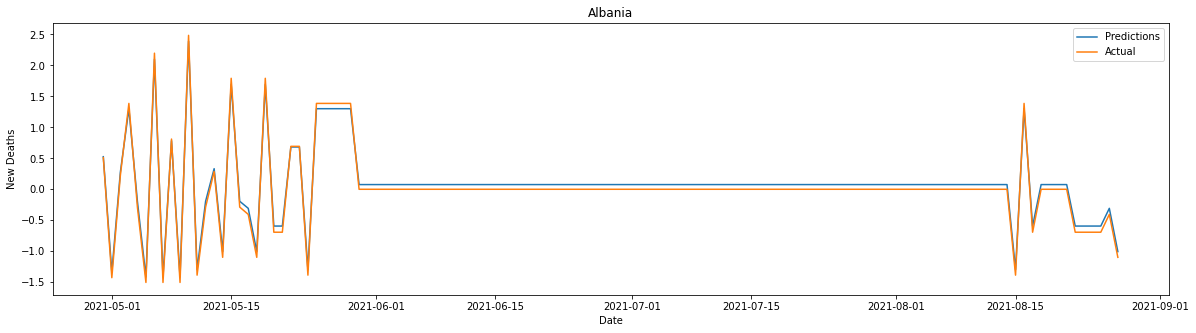

Country: Austria - C: 1.0 - SVR Score: 0.9966475215754105


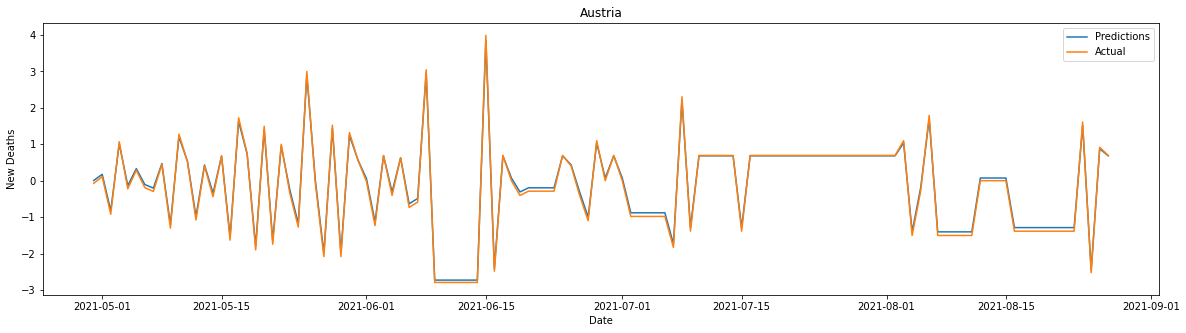

Country: Belarus - C: 1.0 - SVR Score: 0.8748758353997279


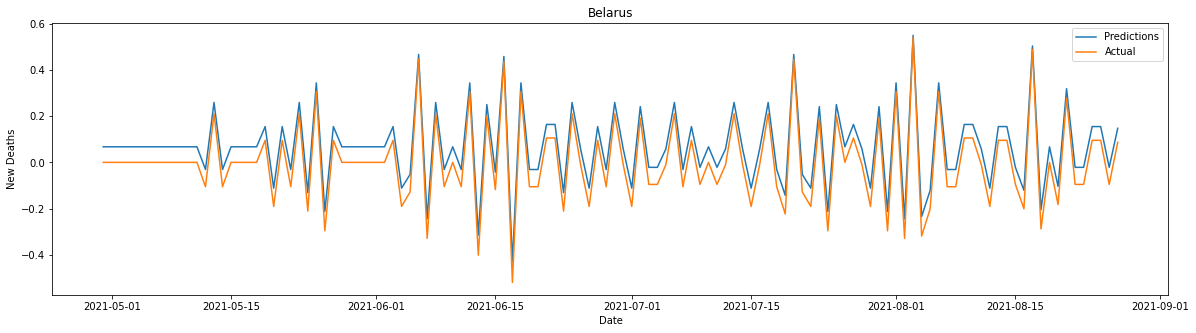

Country: Belgium - C: 1.0 - SVR Score: 0.986301092807783


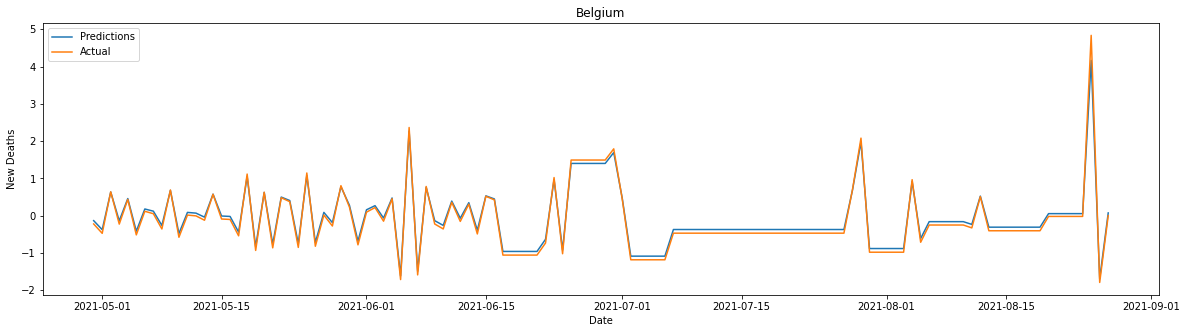

Country: Bosnia and Herzegovina - C: 1.0 - SVR Score: 0.989638729060195


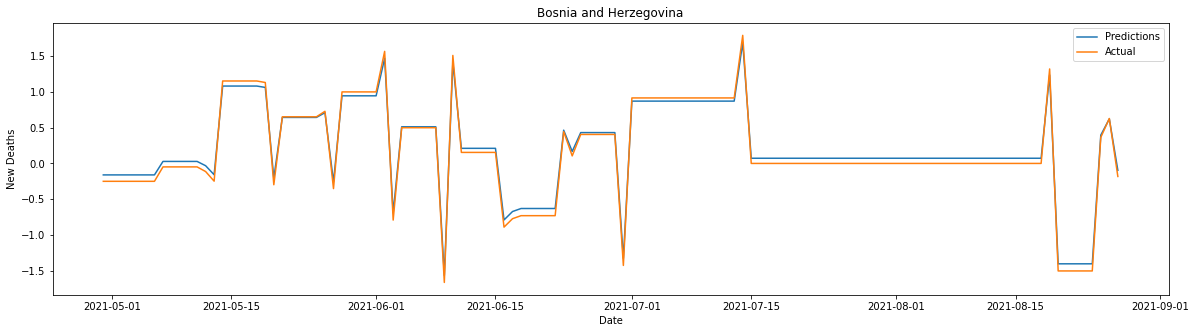

Country: Bulgaria - C: 1.0 - SVR Score: 0.9950754966934335


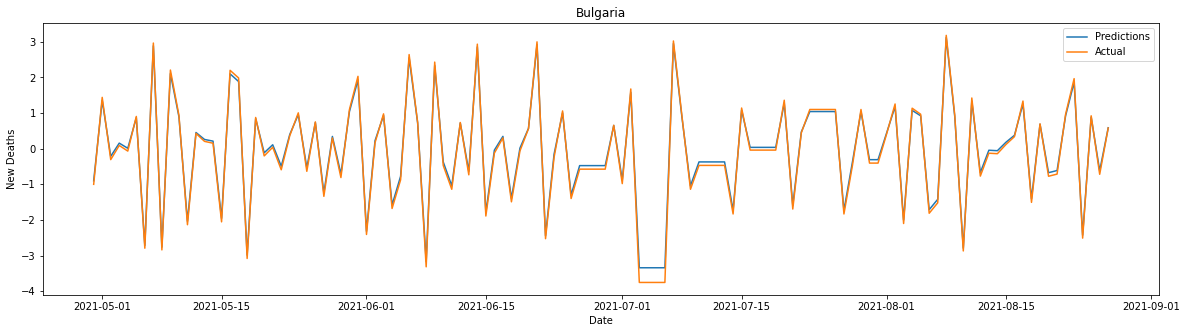

Country: Croatia - C: 1.0 - SVR Score: 0.9922229055236927


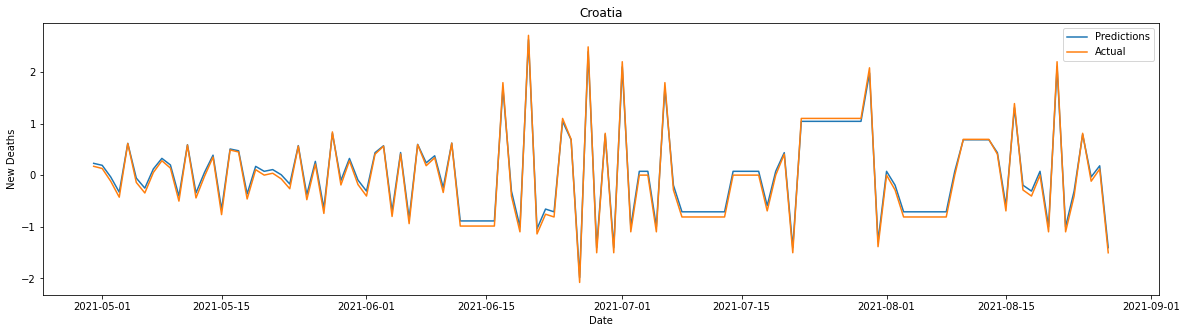

Country: Cyprus - C: 1.0 - SVR Score: 0.9956935925972208


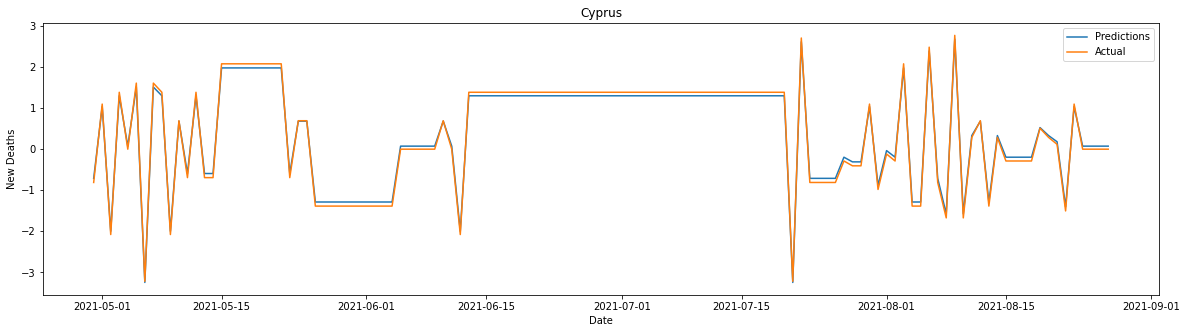

Country: Czechia - C: 1.0 - SVR Score: 0.9968821937088538


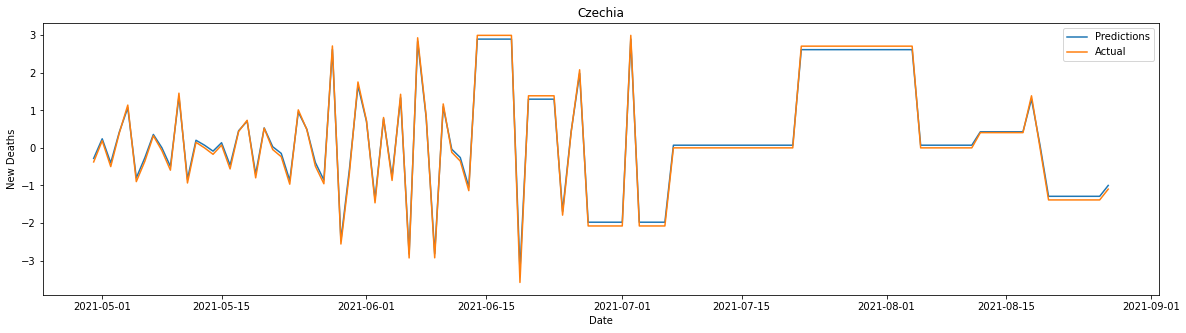

Country: Denmark - C: 1.0 - SVR Score: 0.9895543784666992


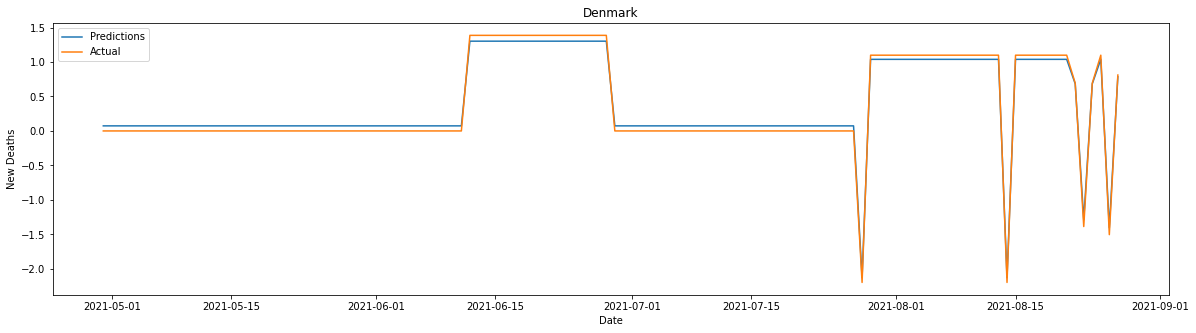

Country: Estonia - C: 1.0 - SVR Score: 0.997037796992173


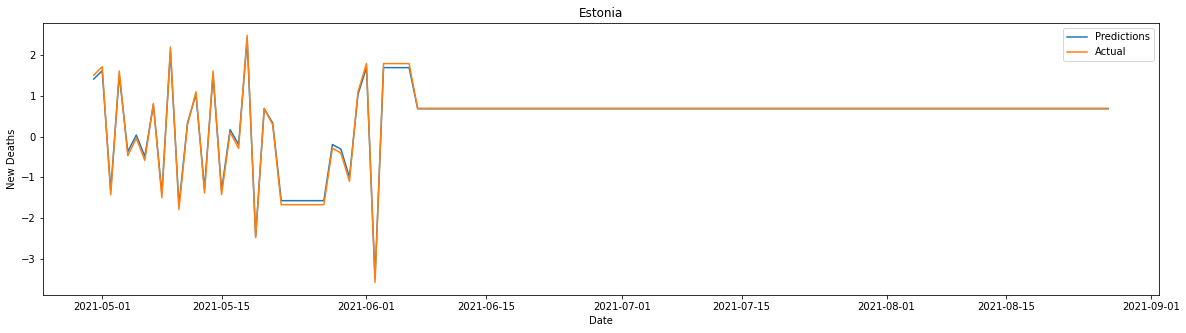

Country: Finland - C: 1.0 - SVR Score: 0.9943835509756704


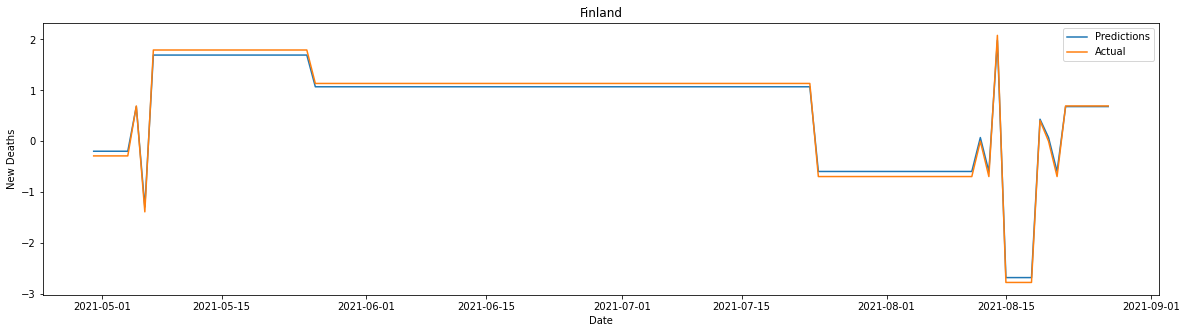

Country: France - C: 1.0 - SVR Score: 0.9931812493734834


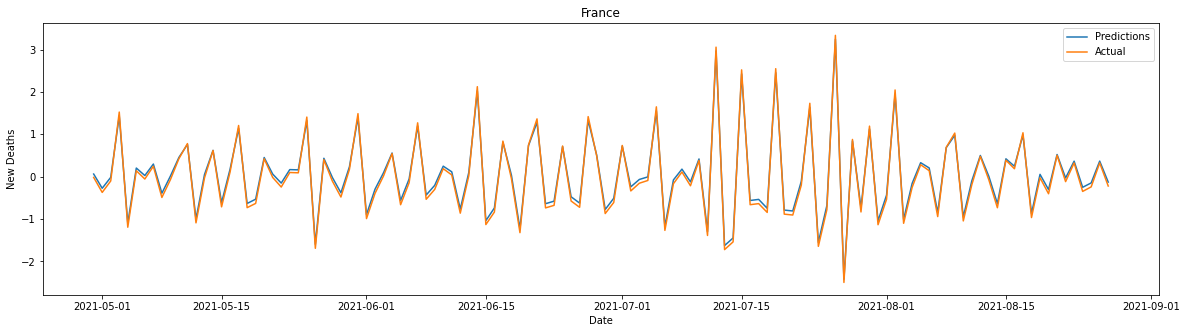

Country: Germany - C: 1.0 - SVR Score: 0.9954035710322398


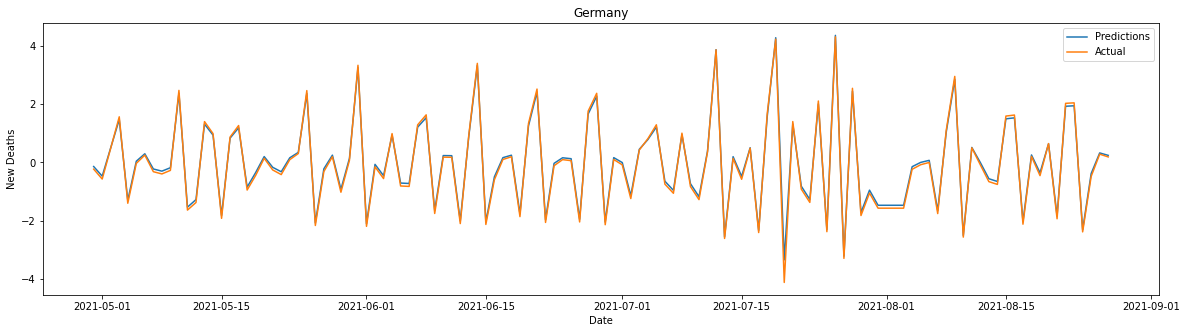

Country: Greece - C: 1.0 - SVR Score: 0.9877319822380479


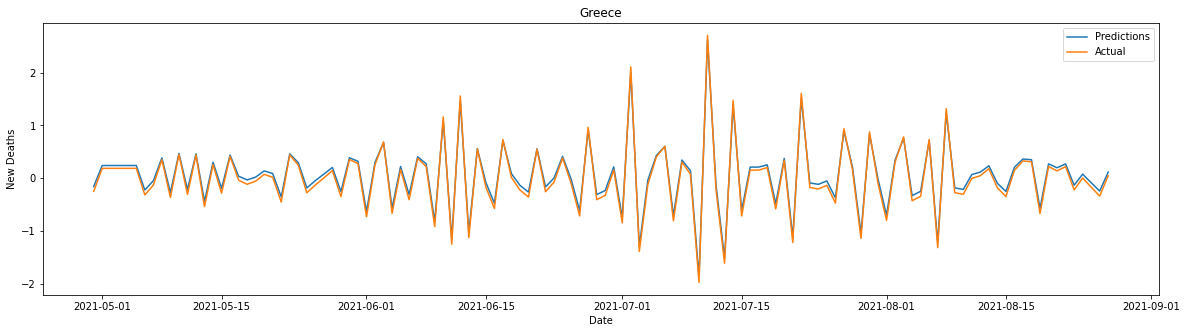

Country: Hungary - C: 1.0 - SVR Score: 0.9946182486545354


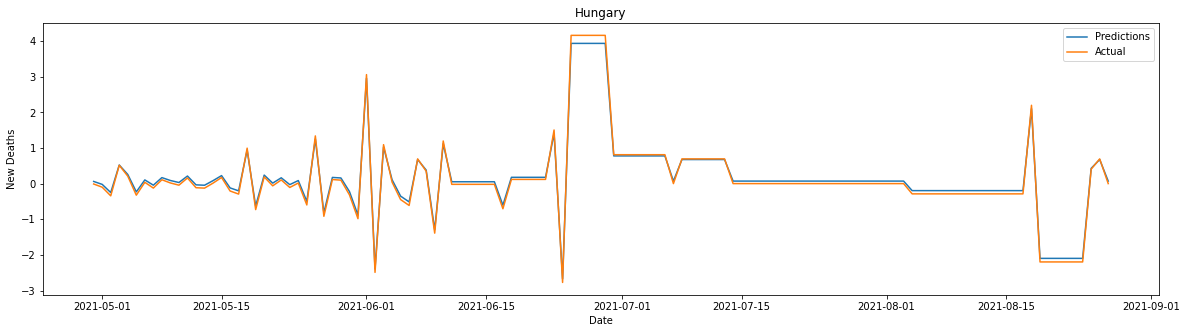

Country: Ireland - C: 1.0 - SVR Score: 0.9853411158588488


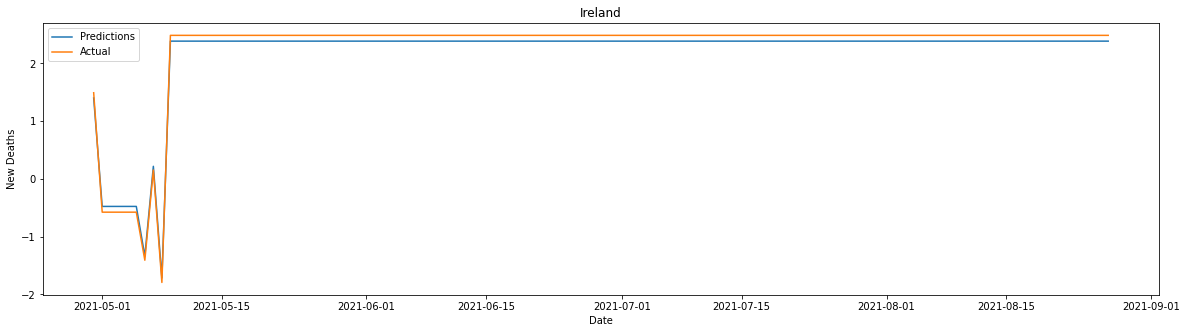

Country: Italy - C: 1.0 - SVR Score: 0.9899586688882328


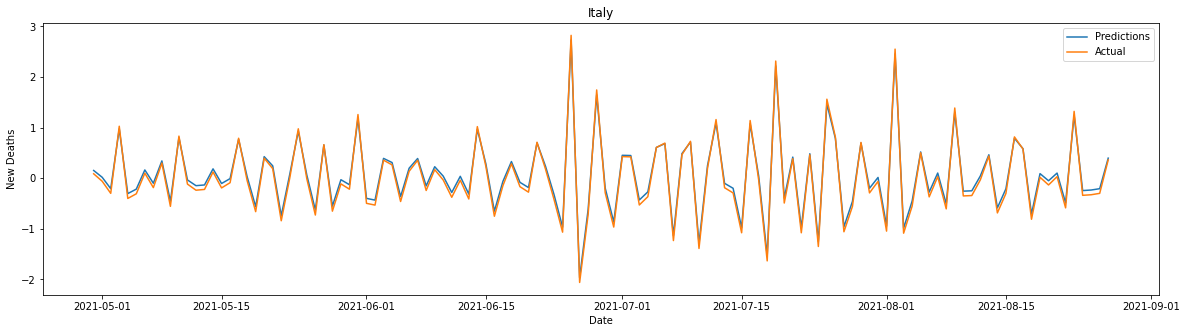

Country: Kosovo - C: 1.0 - SVR Score: 0.9878257567344134


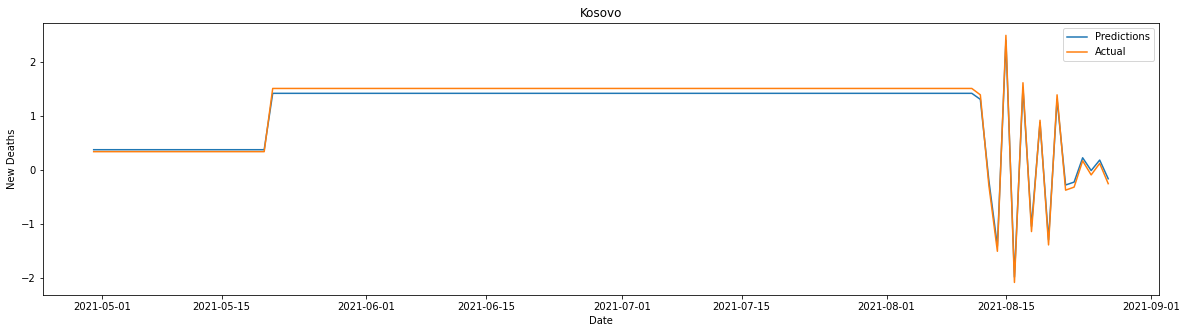

Country: Latvia - C: 1.0 - SVR Score: 0.9960140714354121


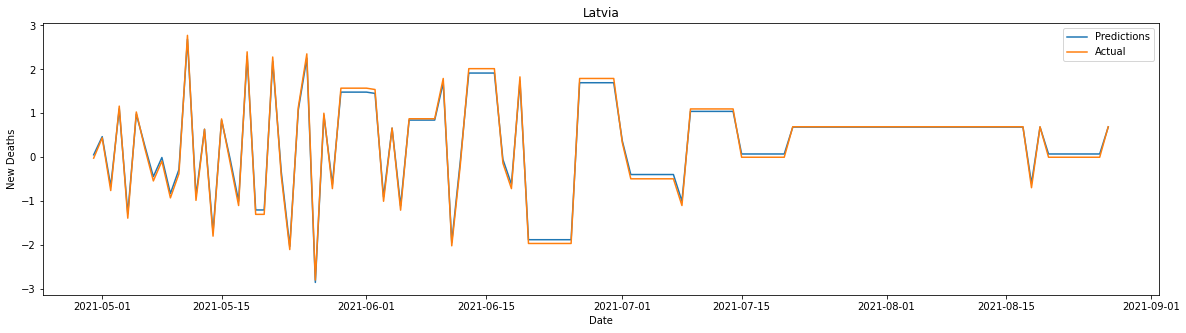

Country: Lithuania - C: 1.0 - SVR Score: 0.99446834808318


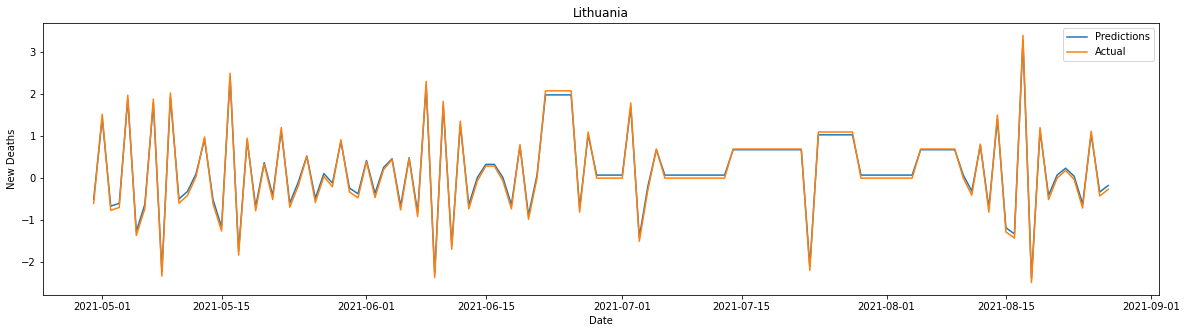

Country: Luxembourg - C: 1.0 - SVR Score: 0.8957919834193842


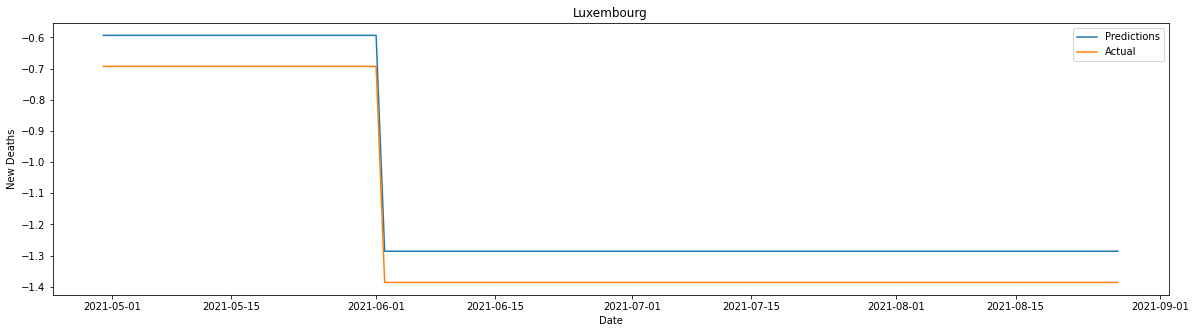

Country: Malta - C: 1.0 - SVR Score: 0.0


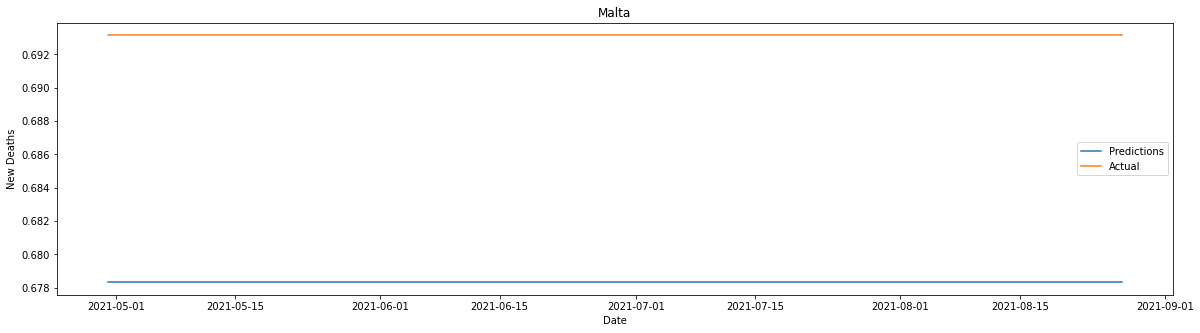

Country: Moldova - C: 1.0 - SVR Score: 0.9797247994626462


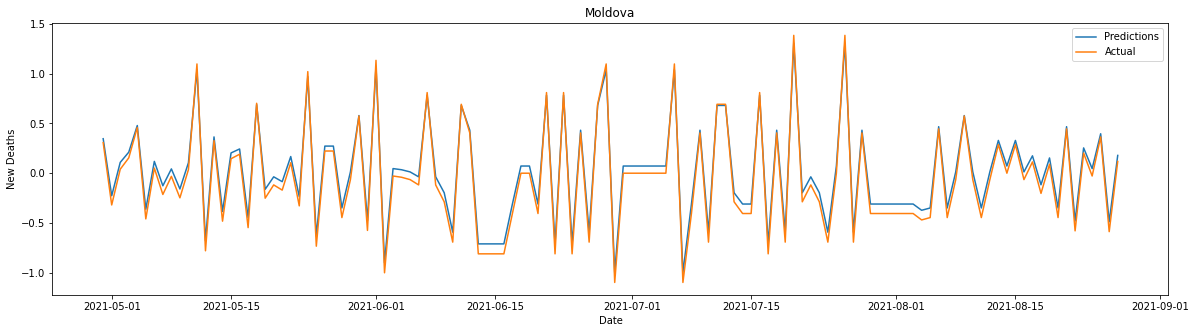

Country: Montenegro - C: 1.0 - SVR Score: 0.9909005583296862


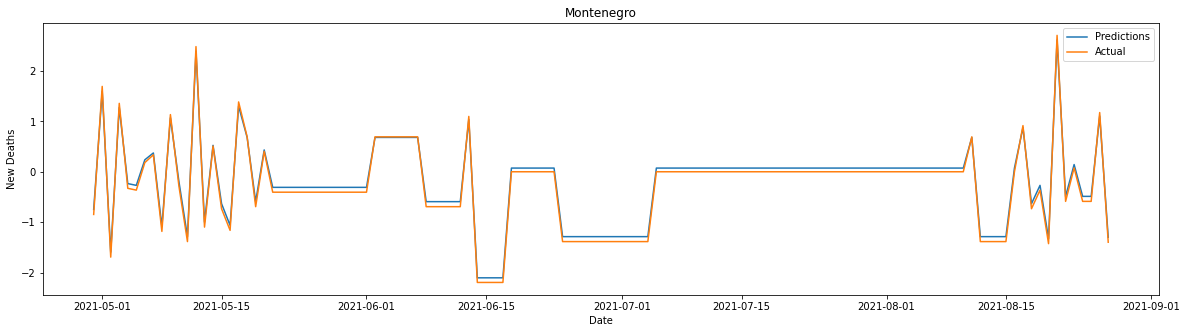

Country: Netherlands - C: 1.0 - SVR Score: 0.9952765038888302


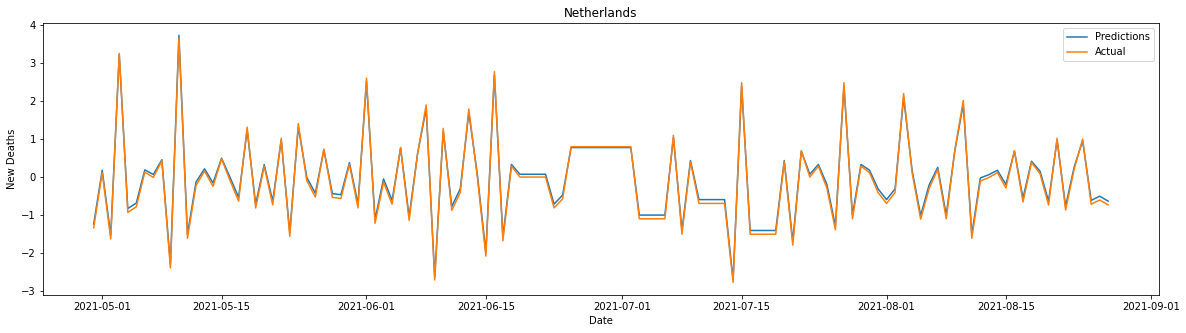

Country: North Macedonia - C: 1.0 - SVR Score: 0.9910976232722344


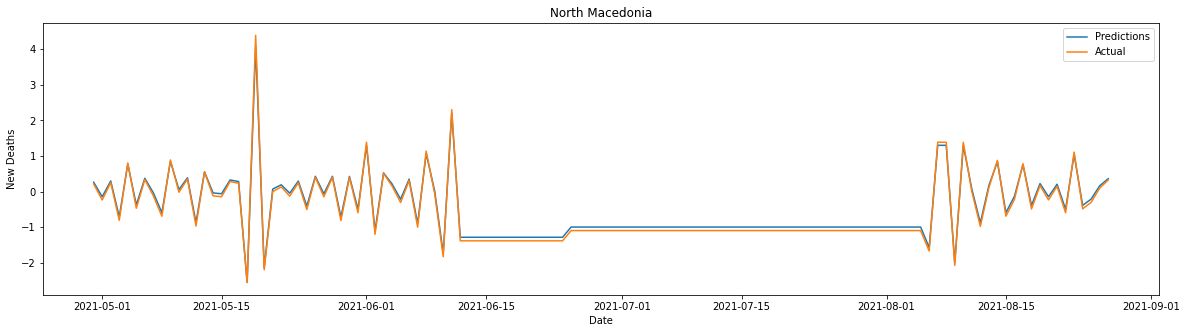

Country: Norway - C: 1.0 - SVR Score: 0.9871001480625693


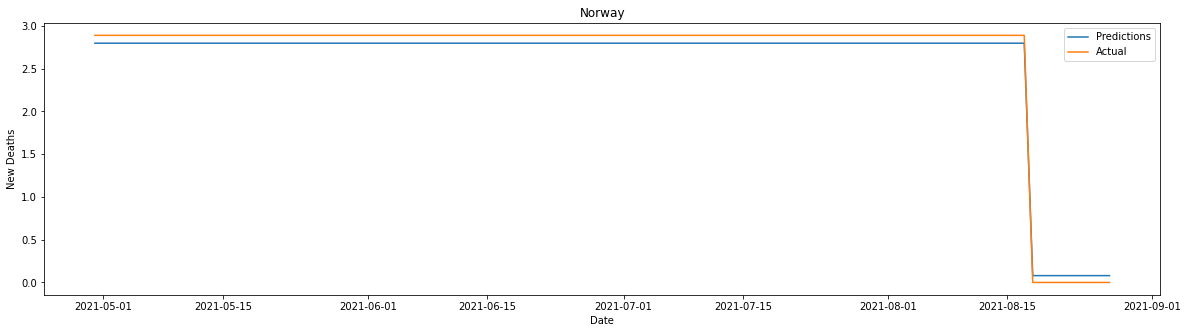

Country: Poland - C: 1.0 - SVR Score: 0.9655345602753861


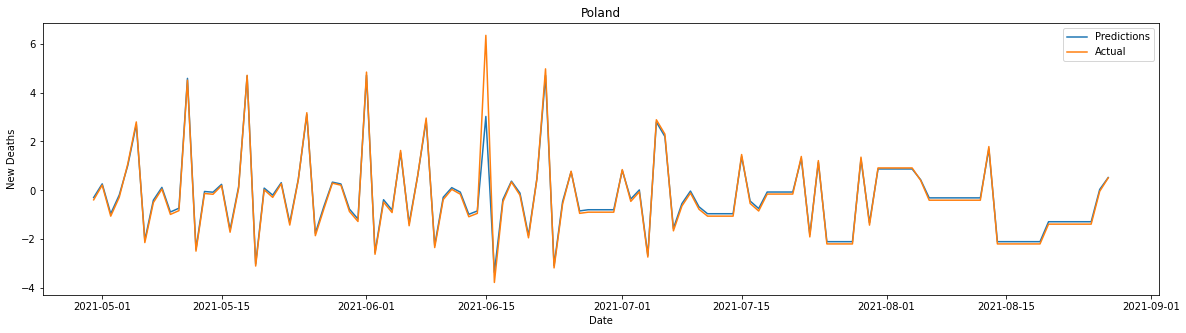

Country: Portugal - C: 1.0 - SVR Score: 0.9959372130833587


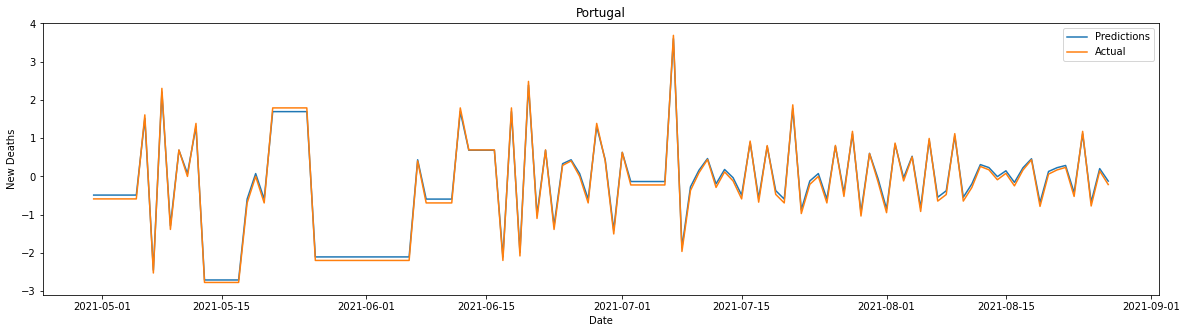

Country: Romania - C: 1.0 - SVR Score: 0.9915450196482739


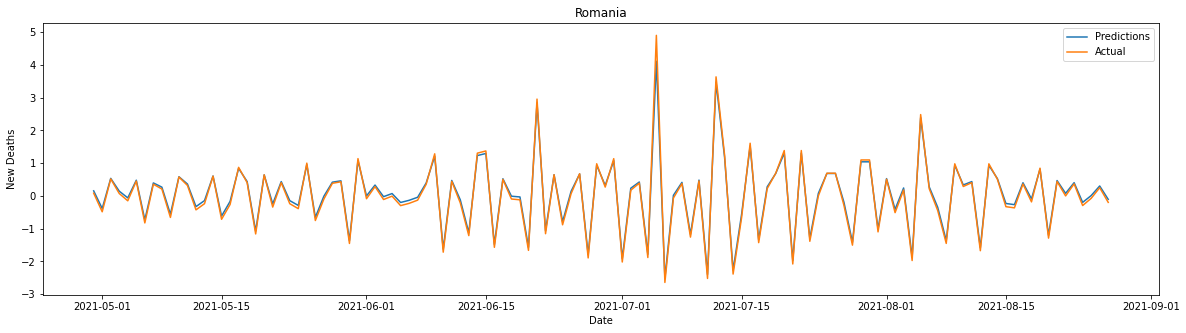

Country: Russia - C: 1.0 - SVR Score: 0.25557847669150113


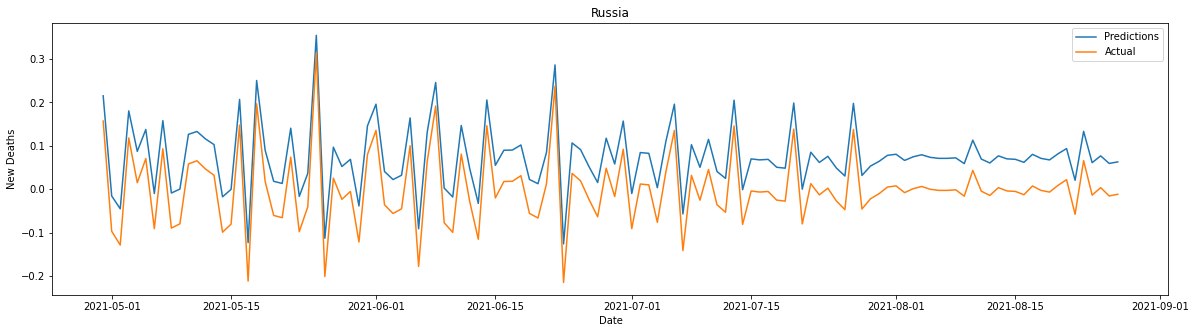

Country: Serbia - C: 1.0 - SVR Score: 0.9929961708502169


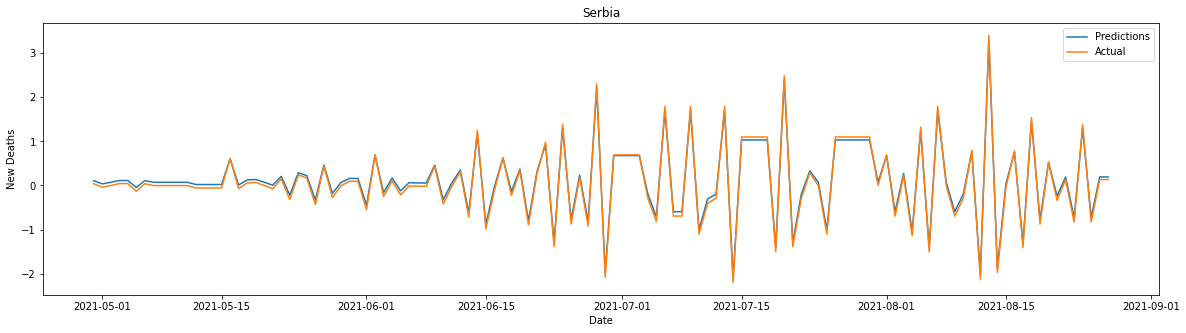

Country: Slovakia - C: 1.0 - SVR Score: 0.9841330421262744


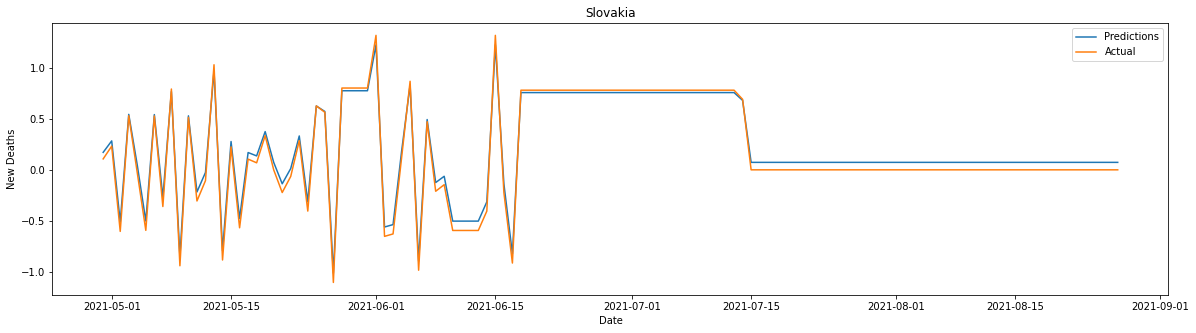

Country: Slovenia - C: 1.0 - SVR Score: 0.9920616369627034


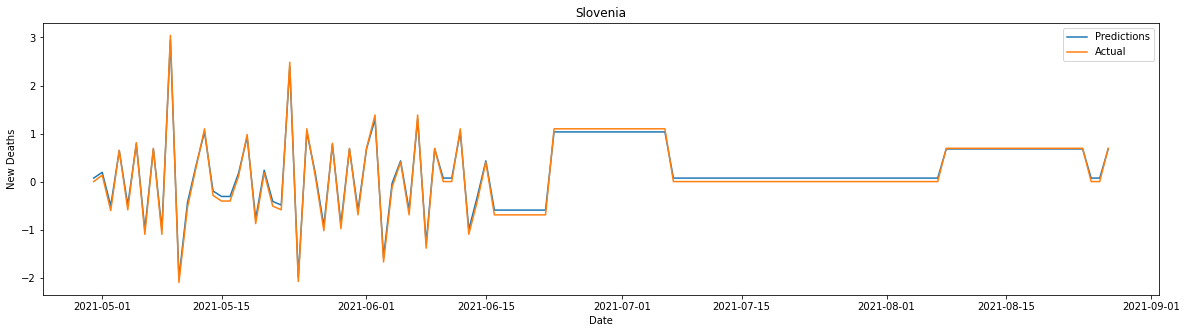

Country: Spain - C: 1.0 - SVR Score: 0.9953431307592868


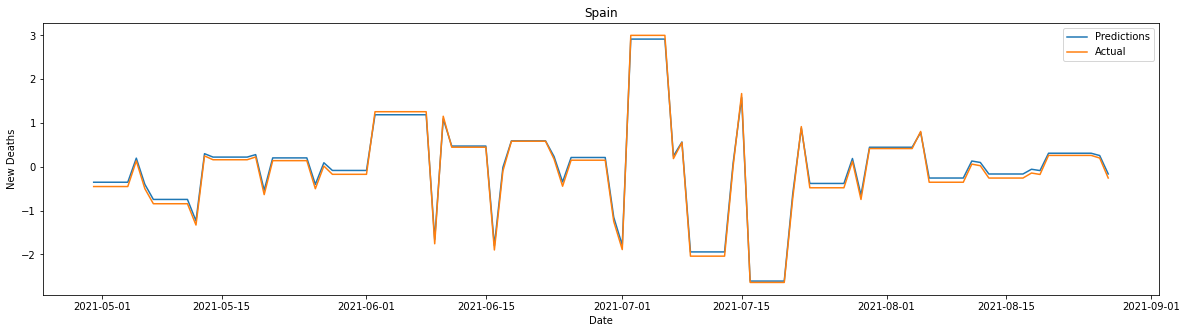

Country: Sweden - C: 1.0 - SVR Score: 0.9339473207000263


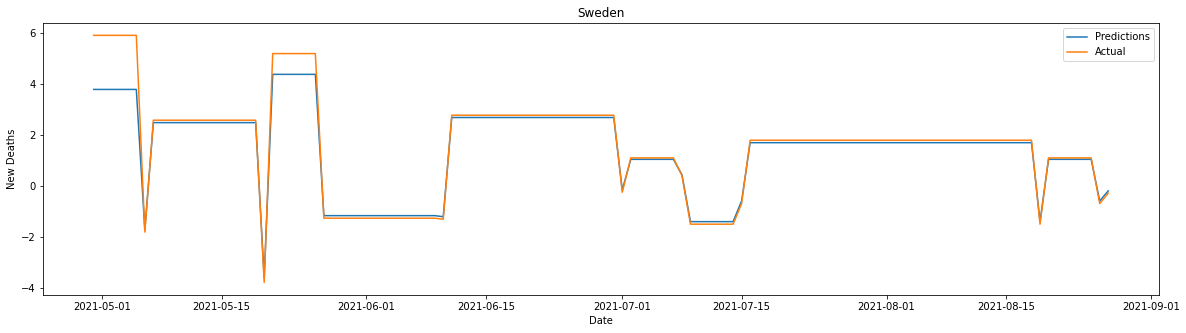

Country: Switzerland - C: 1.0 - SVR Score: 0.9940082886449869


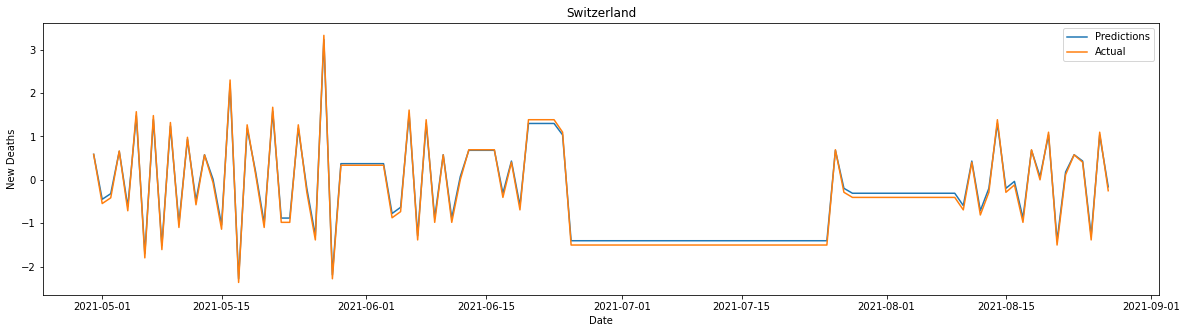

Country: Ukraine - C: 1.0 - SVR Score: 0.989197408010006


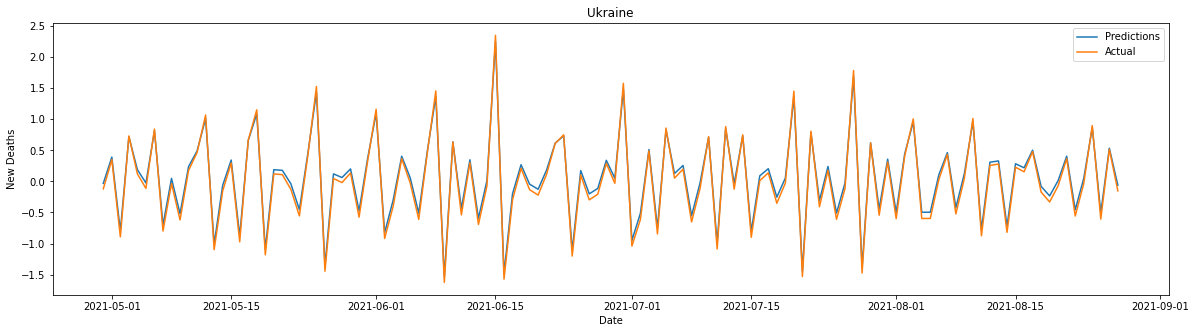

Country: United Kingdom - C: 1.0 - SVR Score: 0.996370418693368


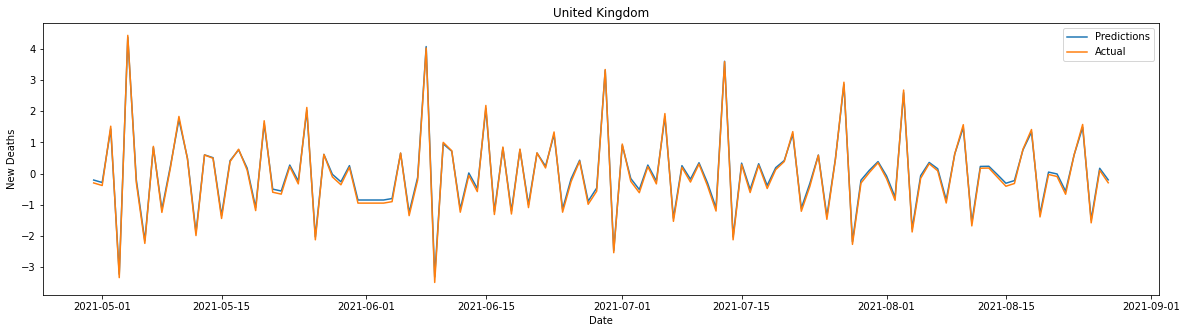

Country: United States - C: 1.0 - SVR Score: 0.9938136985043684


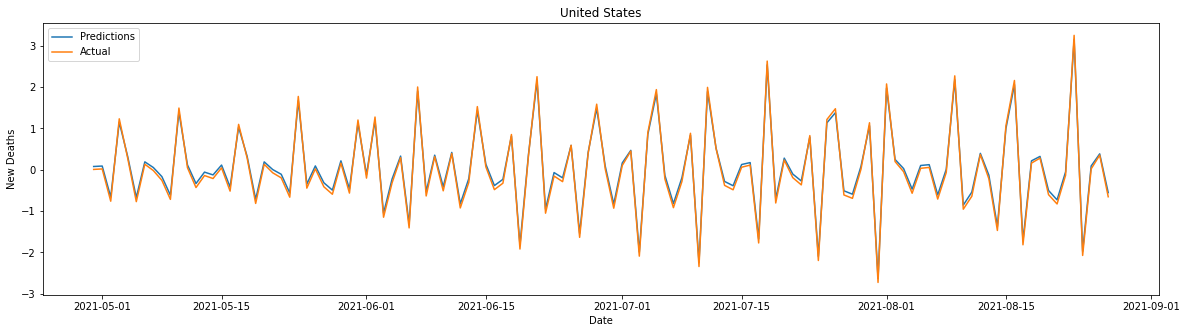

In [551]:
cross_validation()